### **Segmentation**
---

- Travail sur une segmentation from scratch de nos documents
- Formattage des tailles de sorties des caractères extraits pour passage dans un modèle

In [16]:
# Imports
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#### **Binarisation**
---

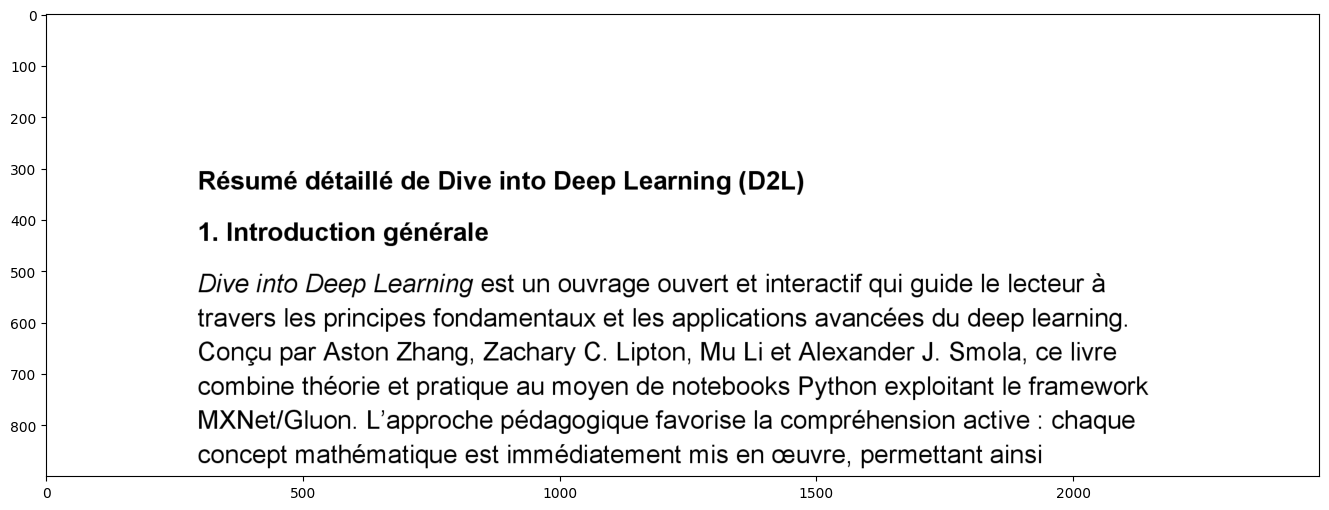

In [17]:
test_document = Image.open("data/imgs/doc1.png").convert("L")

plt.figure(figsize=(18, 6))

plt.imshow(np.array(test_document)[:900, :], cmap='grey')
plt.show()

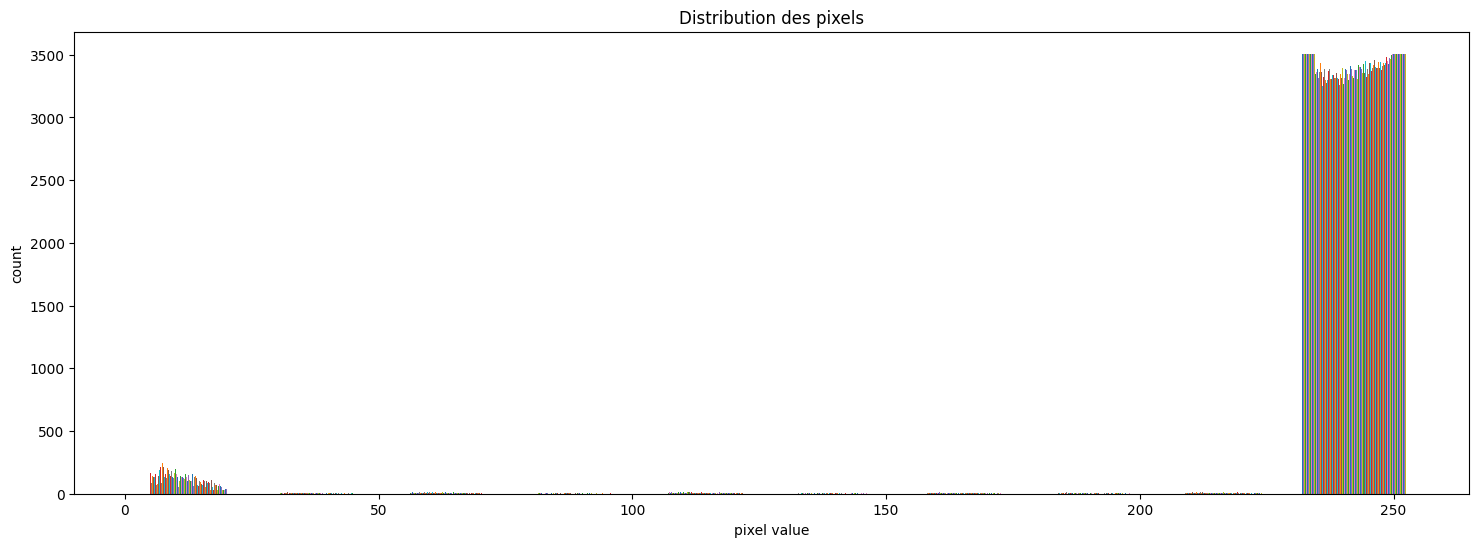

In [18]:
doc_array = np.array(test_document)

plt.figure(figsize=(18, 6))

plt.hist(doc_array)
plt.title("Distribution des pixels")
plt.xlabel('pixel value')
plt.ylabel('count')

plt.show()

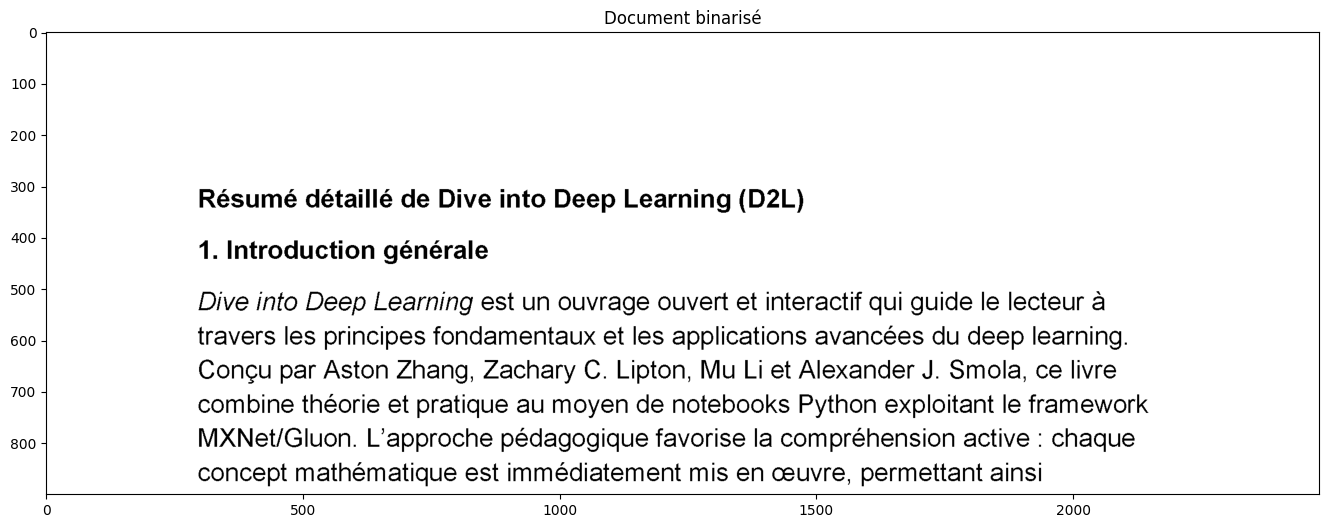

In [19]:
doc_binary = np.zeros_like(doc_array, dtype=np.uint8)
doc_binary[doc_array > 100] = 1
doc_binary[doc_binary != 1] = 0

plt.figure(figsize=(18, 6))

plt.imshow(np.array(doc_binary)[:900, :], cmap='grey')
plt.title("Document binarisé")

plt.show()

In [ ]:
def load_binarize(file_path):
    file = Image.open(file_path).convert("L")
    file_array = np.array(file)

    file_binary = np.zeros_like(file_array, dtype=np.uint8)
    file_binary[file_array > 100] = 1
    file_binary[file_binary != 1] = 0

    return file_binary

#### **Profiling**
---

- On cherche les cassures sur les profiles verticaux et horizontaux des pixels afin de différencier les interlignes des blocs de test.

In [21]:
threshold = 0.999
j = 0

# Init
line_breaks = []
block = 1
writings = False

# Parcours ligne par ligne
for i, row in enumerate(doc_binary):
    white_ratio = row.mean()
    
    if white_ratio > threshold:
        # ligne blanche
        line_breaks.append(0)
        if writings:
            block += 1
            writings = False
    else:
        # ligne écrite
        writings = True
        line_breaks.append(block)
        if j <= 5:
            print(f"Ligne {i:03d} - blanc : {white_ratio:.3f}", end=f" → écriture (bloc {block})\n")
            j += 1

Ligne 306 - blanc : 0.924 → écriture (bloc 1)
Ligne 307 - blanc : 0.916 → écriture (bloc 1)
Ligne 308 - blanc : 0.912 → écriture (bloc 1)
Ligne 309 - blanc : 0.908 → écriture (bloc 1)
Ligne 310 - blanc : 0.905 → écriture (bloc 1)
Ligne 311 - blanc : 0.904 → écriture (bloc 1)


In [22]:
new_rows = []
size = doc_binary.shape[1]
j = 0

for i, seg in enumerate(line_breaks):
    if seg != 0:
        new_rows.append(doc_binary[i, :])
        if j <= 5:
            print(f"Conserve la ligne {i:03d} (bloc manuscrit {seg})")
            j += 1
    else:
        continue

writings = np.array(new_rows).reshape(-1, size)

print(f"\nTotal lignes conservées : {len(new_rows)}")

Conserve la ligne 306 (bloc manuscrit 1)
Conserve la ligne 307 (bloc manuscrit 1)
Conserve la ligne 308 (bloc manuscrit 1)
Conserve la ligne 309 (bloc manuscrit 1)
Conserve la ligne 310 (bloc manuscrit 1)
Conserve la ligne 311 (bloc manuscrit 1)

Total lignes conservées : 739


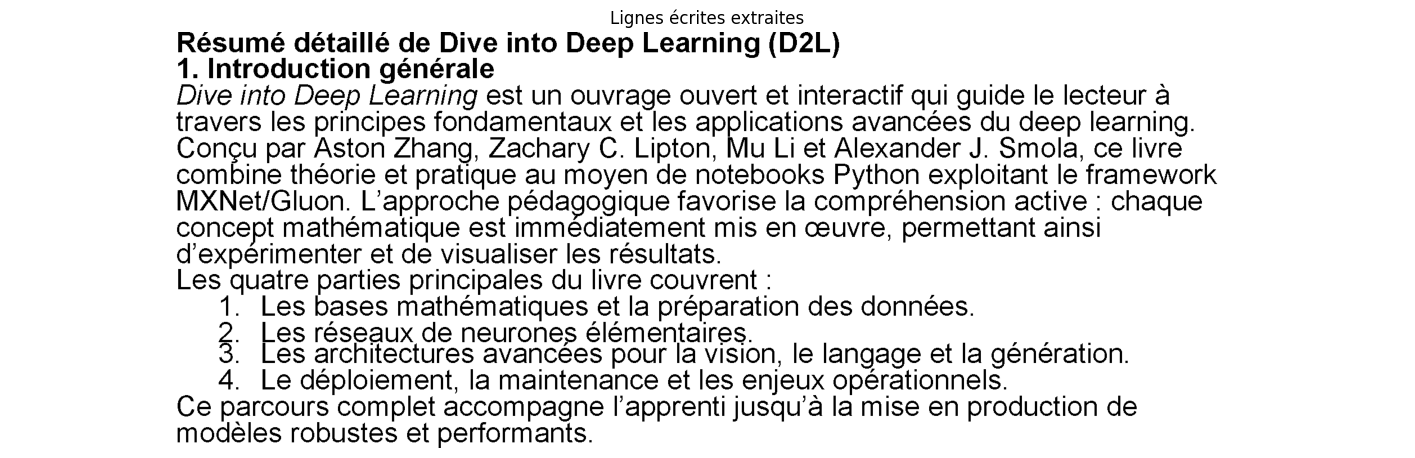

In [23]:
plt.figure(figsize=(18, 8))

plt.imshow(writings, cmap='gray')
plt.title("Lignes écrites extraites")
plt.axis('off')

plt.show()

In [24]:
character_list = []
unique_lines = sorted(set(line_breaks))
print("Lignes identifiées :", unique_lines)

for line_id in unique_lines:
    # récupération lignes du bloc de l'itératon
    line_rows = [idx for idx, val in enumerate(line_breaks) if val == line_id]
    sub_writing = doc_binary[line_rows, :]
    
    # Parcours des colonnes pour trouver les caractères
    in_letter = False
    start_col = 0
    
    for col in range(sub_writing.shape[1]):
        col_min = sub_writing[:, col].min()
        
        if col_min == 0 and not in_letter:
            # Début d'un caractère
            in_letter = True
            start_col = col
        elif col_min != 0 and in_letter:
            # Fin d'un caractère
            end_col = col
            letter_img = sub_writing[:, start_col:end_col]
            character_list.append((letter_img != 0).astype(int))
            in_letter = False
    
    # Cas où le dernier caractère va jusqu'à la fin de la ligne
    if in_letter:
        letter_img = sub_writing[:, start_col:]
        character_list.append((letter_img != 0).astype(int))

print(f"\nNombre total de caractères segmentés : {len(character_list)}")

Lignes identifiées : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

Nombre total de caractères segmentés : 837


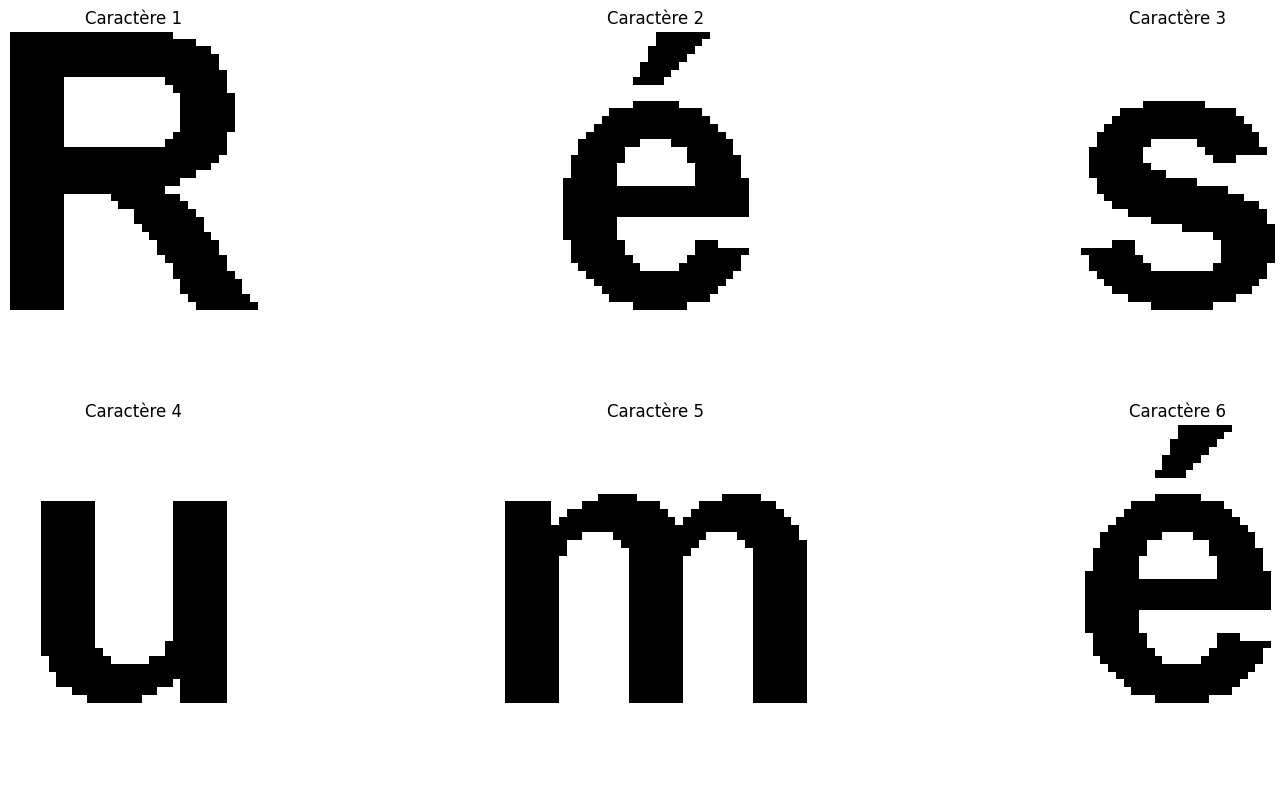

In [25]:
def show_firsts_characters(character_list):
    num_chars = min(6, len(character_list))
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    for idx in range(num_chars):
        ax = axes.flat[idx]
        ax.imshow(character_list[idx], cmap='gray')
        ax.set_title(f"Caractère {idx+1}")
        ax.axis('off')

    for idx in range(num_chars, 6):
        axes.flat[idx].axis('off')

    plt.tight_layout()
    plt.show()
    
show_firsts_characters(character_list)

In [ ]:
def characters_extraction(doc_binary, threshold=0.999):
    line_breaks = []
    block = 1
    writings_flag = False

    for i, row in enumerate(doc_binary):
        white_ratio = row.mean()
        if white_ratio > threshold:
            line_breaks.append(0)
            if writings_flag:
                block += 1
                writings_flag = False
        else:
            writings_flag = True
            line_breaks.append(block)

    new_rows = [doc_binary[i, :] for i, seg in enumerate(line_breaks) if seg != 0]
    writings = np.array(new_rows)

    character_list = []
    unique_lines = sorted(set(line_breaks) - {0})
    for line_id in unique_lines:
        line_indices = [i for i, seg in enumerate(line_breaks) if seg == line_id]
        sub_writing = doc_binary[line_indices, :]

        in_letter = False
        start_col = 0
        for col in range(sub_writing.shape[1]):
            if sub_writing[:, col].min() == 0 and not in_letter:
                in_letter = True
                start_col = col
            elif sub_writing[:, col].min() != 0 and in_letter:
                letter_img = sub_writing[:, start_col:col]
                character_list.append((letter_img != 0).astype(np.uint8))
                in_letter = False

        if in_letter:
            letter_img = sub_writing[:, start_col:]
            character_list.append((letter_img != 0).astype(np.uint8))

    return line_breaks, writings, character_list

#### **Redimensionnement**
---

In [27]:
padded_chars = []

for idx, char_roi in enumerate(character_list):
    h, w = char_roi.shape

    if h > 28 or w > 28:
        scale = 28 / max(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        char_roi = cv2.resize(char_roi.astype(np.uint8),
                              (new_w, new_h),
                              interpolation=cv2.INTER_AREA)
        h, w = new_h, new_w

    padded = np.ones((28, 28), dtype=np.uint8)
    pad_x = (28 - w) // 2
    pad_y = (28 - h) // 2
    padded[pad_y:pad_y + h, pad_x:pad_x + w] = (char_roi)

    padded_chars.append(padded)

print(padded_chars[0].shape)

(28, 28)


In [ ]:
def padding(chars_list):
    padded_chars = []
    for char_roi in chars_list:
        h, w = char_roi.shape
        if h > 28 or w > 28:
            scale = 28 / max(h, w)
            new_h, new_w = int(h * scale), int(w * scale)
            char_roi = cv2.resize(char_roi, (new_w, new_h), interpolation=cv2.INTER_AREA)
            h, w = new_h, new_w

        padded = np.ones((28, 28), dtype=np.uint8)
        pad_x = (28 - w) // 2
        pad_y = (28 - h) // 2
        padded[pad_y:pad_y + h, pad_x:pad_x + w] = char_roi

        prep_nn_char = (padded == 0).astype(np.uint8)
        padded_chars.append(prep_nn_char)

    return padded_chars

#### **Pipeline**
---

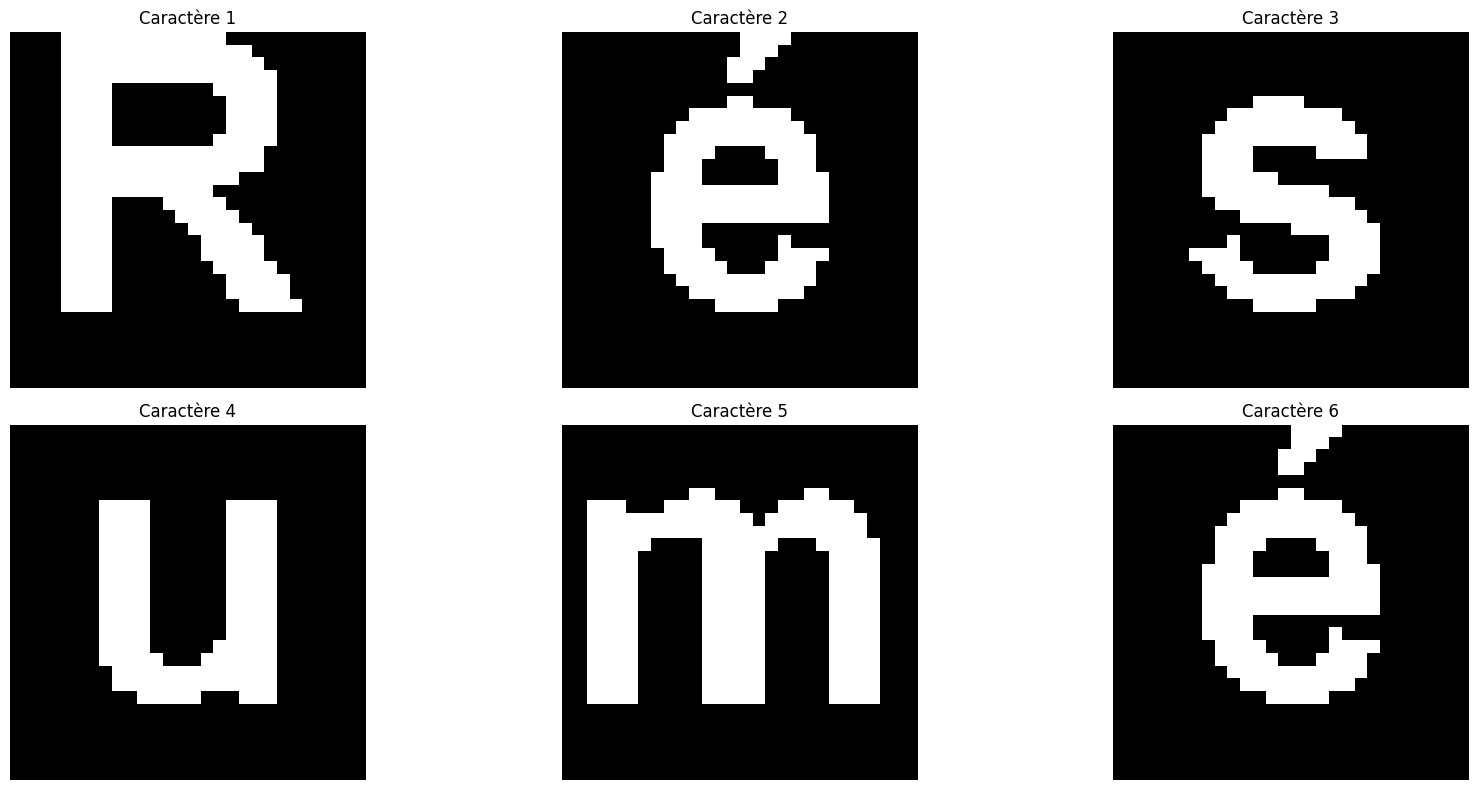

In [ ]:
def _pipeline(file_path):
    bin_img = load_binarize(file_path)
    _, _, chars = characters_extraction(bin_img)
    return padding(chars)

show_firsts_characters(_pipeline("data/imgs/doc1.png"))